In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import gc
from google.colab import files

In [2]:
# Load data
list_of_files = ['PAMAP2_Dataset/Protocol/subject101.dat',
                 'PAMAP2_Dataset/Protocol/subject102.dat',
                 'PAMAP2_Dataset/Protocol/subject103.dat',
                 'PAMAP2_Dataset/Protocol/subject104.dat',
                 'PAMAP2_Dataset/Protocol/subject105.dat',
                 'PAMAP2_Dataset/Protocol/subject106.dat',
                 'PAMAP2_Dataset/Protocol/subject107.dat',
                 'PAMAP2_Dataset/Protocol/subject108.dat',
                 'PAMAP2_Dataset/Protocol/subject109.dat' ]

subjectID = [1,2,3,4,5,6,7,8,9]

activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature', 
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3', 
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3', 
           'handGyro1', 'handGyro2', 'handGyro3', 
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature', 
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3', 
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3', 
           'chestGyro1', 'chestGyro2', 'chestGyro3', 
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature', 
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3', 
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3', 
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3', 
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']

columns = colNames + IMUhand + IMUchest + IMUankle  #all columns in one list

len(columns)

54

In [3]:
base_path = 'drive/MyDrive/'

dataCollection = pd.DataFrame()
for file in list_of_files:
    procData = pd.read_table(base_path + file, header=None, sep='\s+')
    procData.columns = columns
    procData['subject_id'] = int(file[-5])
    dataCollection = dataCollection.append(procData, ignore_index=True)

dataCollection.reset_index(drop=True, inplace=True)
dataCollection.head()

<ipython-input-3-5f8a3e4801c9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataCollection = dataCollection.append(procData, ignore_index=True)
<ipython-input-3-5f8a3e4801c9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataCollection = dataCollection.append(procData, ignore_index=True)
<ipython-input-3-5f8a3e4801c9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataCollection = dataCollection.append(procData, ignore_index=True)
<ipython-input-3-5f8a3e4801c9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataCollection = dataCollection.append(procData, ignore_index=True)
<ipython-input-3-5f8a3e4801c9>:8: FutureWarning: The

,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
0,8.38,0,104.0,30.0,2.37223,8.60074,3.51048,2.43954,8.76165,3.35465,...,0.009250,-0.017580,-61.1888,-38.9599,-58.1438,1.0,0.0,0.0,0.0,1
1,8.39,0,NaN,30.0,2.18837,8.56560,3.66179,2.39494,8.55081,3.64207,...,-0.004638,0.000368,-59.8479,-38.8919,-58.5253,1.0,0.0,0.0,0.0,1
2,8.40,0,NaN,30.0,2.37357,8.60107,3.54898,2.30514,8.53644,3.73280,...,0.000148,0.022495,-60.7361,-39.4138,-58.3999,1.0,0.0,0.0,0.0,1
3,8.41,0,NaN,30.0,2.07473,8.52853,3.66021,2.33528,8.53622,3.73277,...,-0.020301,0.011275,-60.4091,-38.7635,-58.3956,1.0,0.0,0.0,0.0,1
4,8.42,0,NaN,30.0,2.22936,8.83122,3.70000,2.23055,8.59741,3.76295,...,-0.014303,-0.002823,-61.5199,-39.3879,-58.2694,1.0,0.0,0.0,0.0,1


# Preprocessing

In [4]:
# PREPROCESSING

'''
FROM README

Note: data labeled with activityID=0 should be discarded in any kind of analysis. This data mainly
covers transient activities between performing different activities, e.g. going from one location to the
next activity's location, or waiting for the preparation of some equipment. Also, different parts of one
subject's recording (in the case when the data collection was aborted for some reason) was put together
during these transient activities (noticeable by some “jumping” in the HR-data).
'''

NUMSUBJECTS = 9

# remove points with activityID 0
data = dataCollection[dataCollection['activityID'] != 0]
data.head()


# taken from subjectInformation.pdf
resting_heartrates = [75, 74, 68, 58, 70, 60, 60, 66, 54]
processed_heartrates = []

for i in range(1, NUMSUBJECTS+1):
  # select heartrate of a subject
  arr = data[data['subject_id'] == i]['heartrate']

  # append resting heartrate to beginning and end to make interpolation easier
  new_row = pd.DataFrame({resting_heartrates[i-1]}, index=[0])
  arr = pd.concat([new_row, arr, new_row]).reset_index(drop=True)
  arr = arr.interpolate(method='linear')

  # remove the extra rows which we added
  arr.drop([0, len(arr)-1], axis=0, inplace=True)

  processed_heartrates += list(arr[0])
  
# print(processed_heartrates[:40])
data['heartrate'] = processed_heartrates

# linearly interpolate other columns as well
for column in data.columns:
  data[column] = data[column].interpolate(method='linear')

data.head()

# normalize data but do not normalize these 3 columns
timestamp = list(data['timestamp'])
activityID = list(data['activityID'])
subjectID = list(data['subject_id'])
normalized_data = (data - data.mean()) / data.std()
normalized_data['timestamp'] = timestamp
normalized_data['activityID'] = activityID
normalized_data['subject_id'] = subjectID
normalized_data.head()


# arr = data['activityID']
# print(set(list(arr)))
# print(len(list(arr)))

<ipython-input-4-e3ce79788bdf>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['heartrate'] = processed_heartrates
<ipython-input-4-e3ce79788bdf>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column] = data[column].interpolate(method='linear')


,timestamp,activityID,heartrate,handTemperature,handAcc16_1,handAcc16_2,handAcc16_3,handAcc6_1,handAcc6_2,handAcc6_3,...,ankleGyro2,ankleGyro3,ankleMagne1,ankleMagne2,ankleMagne3,ankleOrientation1,ankleOrientation2,ankleOrientation3,ankleOrientation4,subject_id
2928,37.66,1,-1.018329,-1.324438,1.148824,0.680921,0.501723,1.142044,0.755770,0.503315,...,0.013808,-0.002437,-1.608948,-1.764234,-3.837307,2.037571,0.015747,-0.908957,0.118701,1
2929,37.67,1,-0.833088,-1.324438,1.161110,0.592976,0.541436,1.146341,0.693863,0.507363,...,0.058704,-0.000324,-1.597148,-1.739154,-3.837104,2.037571,0.015747,-0.908957,0.118701,1
2930,37.68,1,-0.647848,-1.324438,1.160940,0.516025,0.561337,1.145690,0.620530,0.507634,...,-0.024899,-0.005733,-1.567120,-1.714462,-3.849603,2.037571,0.015747,-0.908957,0.118701,1
2931,37.69,1,-0.462607,-1.324438,1.149257,0.516206,0.580514,1.138022,0.558716,0.530851,...,0.027704,0.010081,-1.590225,-1.775264,-3.812458,2.037571,0.015747,-0.908957,0.118701,1
2932,37.70,1,-0.277366,-1.324438,1.162568,0.532876,0.629362,1.135690,0.556450,0.550012,...,-0.019348,-0.006452,-1.559669,-1.776172,-3.812701,2.037571,0.015747,-0.908957,0.118701,1


In [5]:
# DIVIDING INTO TRAIN TEST USING NORMALIZED DATA

from sklearn.model_selection import cross_val_score, train_test_split

y = normalized_data['activityID']
x = normalized_data.drop(['activityID', 'subject_id', 'timestamp'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state=0)
# x_train_no_timestamp = x_train.to_numpy()[:, 1:]
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
# x_test_no_timestamp = x_test.to_numpy()[:, 1:]
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

print(type(x_test))
print(type(y_test))

del data, normalized_data
gc.collect()


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


0

In [6]:
print(set(y_test.tolist()))
print(set(y_train.tolist()))

{1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24}
{1, 2, 3, 4, 5, 6, 7, 12, 13, 16, 17, 24}


In [7]:
x_train_handIMU = x_train[:, :18] # hand IMU and heartrate
x_test_handIMU = x_test[:, :18]

In [8]:
import seaborn as sns

def plot_confusion_matrix(y_truth, y_pred):
  cf = confusion_matrix(y_truth, y_pred)
  # print(len(cf))
  labels = ["{0:0.0f}".format(value) for value in cf.flatten()]
  labels = np.asarray(labels).reshape(12,12)
  # print(labels)
  sns.heatmap(cf, annot=labels, fmt='', cmap='Blues')

In [ ]:
# print(data['ankleOrientation1'].isnull().sum().sum())

# for column in data.columns:
#   print(data[column])

# Logistic Regression

In [9]:
%%time
# LOGISTIC REGRESSION (full features)


from sklearn.linear_model import LogisticRegression
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

logistic_clf = LogisticRegression(solver='sag', penalty='l2', C=0.001, random_state=0, max_iter=200, tol=0.003)
scores = cross_val_score(logistic_clf, x_train, y_train, cv=5)
print(scores)

(1651441, 52) (291431, 52) (1651441,) (291431,)
[0.84555647 0.84479    0.84512002 0.84431769 0.84442365]
CPU times: user 3min 57s, sys: 1.73 s, total: 3min 59s
Wall time: 4min 6s


In [10]:
%%time
y_pred = logistic_clf.fit(x_train, y_train).predict(x_test)
print(y_pred[:40])
# print(classification_report(y_pred, ))

[17  2  7  6  4  1  1  1  7  7  4 13 16  6  6  3  5  4 16 17  2  7  1  4
 16  4  7  5 17 24 16  7  1  2  6 12  7  1 13 13]
CPU times: user 57.9 s, sys: 311 ms, total: 58.2 s
Wall time: 58.2 s


              precision    recall  f1-score   support

           1      0.966     0.981     0.973     28616
           2      0.937     0.931     0.934     28143
           3      0.865     0.841     0.853     29097
           4      0.897     0.816     0.855     39645
           5      0.770     0.818     0.794     13804
           6      0.942     0.939     0.941     24839
           7      0.816     0.783     0.799     29257
          12      0.585     0.662     0.621     15501
          13      0.514     0.639     0.570     12649
          16      0.815     0.838     0.826     25589
          17      0.937     0.886     0.911     37672
          24      0.718     0.803     0.758      6619

    accuracy                          0.848    291431
   macro avg      0.814     0.828     0.820    291431
weighted avg      0.855     0.848     0.851    291431



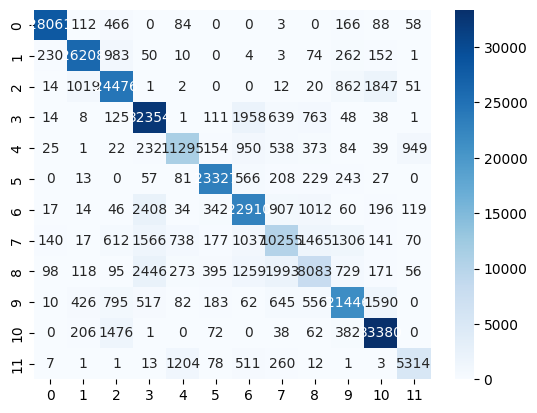

In [11]:
print(classification_report(y_pred, y_test, digits=3))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'logistic7_full'
pickle.dump(logistic_clf, open(name, 'wb'))
files.download(name) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time
# LOGISTIC REGRESSION (partial features)


from sklearn.linear_model import LogisticRegression
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

logistic_clf = LogisticRegression(solver='sag', penalty='l2', C=10, random_state=0, max_iter=200, tol=0.003)
scores = cross_val_score(logistic_clf, x_train_handIMU, y_train, cv=5)
print(scores)

(1651441, 52) (291431, 52) (1651441,) (291431,)
[0.56513841 0.56619677 0.56499176 0.56402291 0.56578804]
CPU times: user 59.8 s, sys: 569 ms, total: 1min
Wall time: 1min 2s


In [ ]:
%%time
y_pred = logistic_clf.fit(x_train_handIMU, y_train).predict(x_test_handIMU)
print(y_pred[:40])
# print(classification_report(y_pred, ))

[17  2  4  6  3  1  1  6  4 16  4  4  4  6  6  4  7  4 16  2  2  6  1  4
  3  4  4 17 17  5  4  6  7  2  6  4  4  1  4  6]
CPU times: user 13 s, sys: 82.6 ms, total: 13.1 s
Wall time: 16.6 s


              precision    recall  f1-score   support

           1      0.922     0.738     0.820     36261
           2      0.619     0.779     0.689     22230
           3      0.640     0.509     0.567     35623
           4      0.754     0.490     0.594     55459
           5      0.353     0.589     0.441      8781
           6      0.789     0.648     0.712     30108
           7      0.443     0.491     0.466     25343
          12      0.168     0.545     0.256      5395
          13      0.021     0.276     0.039      1182
          16      0.416     0.458     0.436     23928
          17      0.798     0.603     0.687     47112
          24      0.001     0.889     0.002         9

    accuracy                          0.580    291431
   macro avg      0.494     0.585     0.476    291431
weighted avg      0.681     0.580     0.616    291431



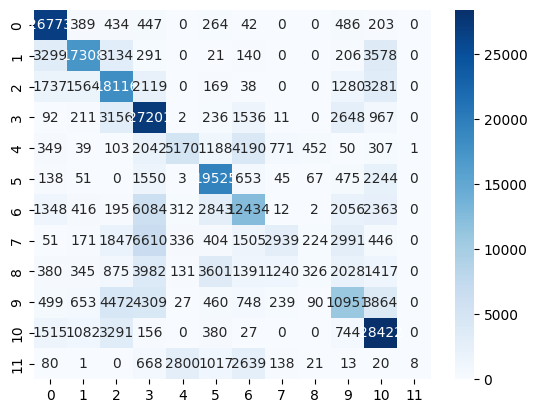

In [ ]:
print(classification_report(y_pred, y_test, digits=3))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'logistic7_partial'
pickle.dump(logistic_clf, open(name, 'wb'))
files.download(name) 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# SVM

In [ ]:
%%time 
# SVM (Full Data)

# Selecting the best hyperparameter using GridSearchCV on a small set

from sklearn import svm
from sklearn.model_selection import GridSearchCV

# use a small dataset first to select optimal hyperparameters
# this is because time complexity for SVM is between O(n^2) and O(n^3)
small_x_train, small_x_test, small_y_train, small_y_test = train_test_split(x, y, train_size=6000, test_size=10000, random_state=0)



parameters = {'kernel':('linear', 'poly', 'rbf'), 'C':[0.01, 0.1, 1, 10, 100, 1000]}

# print(len(x_train), type(x_train))
svm_clf = svm.SVC()
clf = GridSearchCV(svm_clf, parameters)
clf.fit(small_x_train, small_y_train)
# scores = cross_val_score(svm_clf, small_x_train, small_y_train, cv=5)
# print(scores)
sorted(clf.cv_results_.keys())

CPU times: user 47min 49s, sys: 2.94 s, total: 47min 52s
Wall time: 48min 53s


['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'split3_test_score',
 'split4_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [ ]:
print(clf.cv_results_['mean_test_score'])
print(clf.cv_results_['mean_fit_time'])
print(clf.best_estimator_)

[0.8255     0.2445     0.39116667 0.86566667 0.613      0.76683333
 0.86683333 0.88433333 0.914      0.86       0.92433333 0.93866667
 0.8555     0.91866667 0.93883333 0.85133333 0.91833333 0.936     ]
[5.15003633e-01 1.96590929e+00 2.24501591e+00 4.97304773e-01
 1.67547503e+00 1.15639706e+00 1.87062407e+00 1.26533527e+00
 9.01871824e-01 5.41452875e+00 7.48591566e-01 8.32551384e-01
 5.00575459e+01 1.08599153e+00 7.29083014e-01 5.08543027e+02
 7.25913191e-01 8.32716703e-01]
SVC(C=100)


In [ ]:
%%time

# FULL DATA

from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Running on a bigger train set with the best hyperparameters

small_x_train, small_x_test, small_y_train, small_y_test = train_test_split(x, y, train_size=40000, test_size=10000, random_state=0)

svm_clf = svm.SVC(kernel='linear', C=0.1)
# scores = cross_val_score(svm_clf, small_x_train, small_y_train, cv=5)
# print(scores)

CPU times: user 210 ms, sys: 1.06 ms, total: 211 ms
Wall time: 395 ms


In [ ]:
%%time
y_pred = svm_clf.fit(small_x_train, small_y_train).predict(small_x_test)
print(y_pred[:40])

[17  2  5  6  4  1  1  1  7  7  7  4 16  6  6  3  5  4 12 17  2  7  1  4
 16  4  7  5 17 24 16  7  1  2  6 12  7  1 13 13]
CPU times: user 27.4 s, sys: 30.1 ms, total: 27.4 s
Wall time: 29.5 s


              precision    recall  f1-score   support

           1      0.988     0.991     0.989       951
           2      0.969     0.962     0.965       940
           3      0.940     0.917     0.928      1072
           4      0.923     0.847     0.884      1411
           5      0.872     0.823     0.847       515
           6      0.968     0.970     0.969       843
           7      0.878     0.839     0.858      1029
          12      0.664     0.728     0.695       559
          13      0.579     0.772     0.662       417
          16      0.901     0.906     0.904       915
          17      0.954     0.953     0.954      1133
          24      0.799     0.888     0.841       215

    accuracy                          0.896     10000
   macro avg      0.870     0.883     0.875     10000
weighted avg      0.902     0.896     0.898     10000



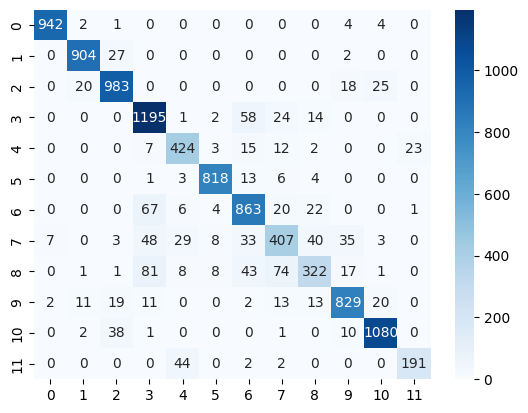

In [ ]:
print(classification_report(y_pred, small_y_test, digits=3))
plot_confusion_matrix(small_y_test, y_pred)

In [ ]:
name = 'SVM'
pickle.dump(svm_clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time

# SVM (Partial Data)

from sklearn import svm
from sklearn.model_selection import GridSearchCV

# Running on a bigger train set with the best hyperparameters

small_x_train, small_x_test, small_y_train, small_y_test = train_test_split(x, y, train_size=40000, test_size=10000, random_state=0)

svm_clf = svm.SVC(kernel='linear', C=0.1)
# scores = cross_val_score(svm_clf, small_x_train, small_y_train, cv=5)
# print(scores)

CPU times: user 226 ms, sys: 0 ns, total: 226 ms
Wall time: 244 ms


In [ ]:
small_x_train = small_x_train.to_numpy()
small_y_train = small_y_train.to_numpy()
# x_test_no_timestamp = x_test.to_numpy()[:, 1:]
small_x_test = small_x_test.to_numpy()
small_y_test = small_y_test.to_numpy()

In [ ]:
small_x_train_handIMU = small_x_train[:, :18] # hand IMU and heartrate
small_x_test_handIMU = small_x_test[:, :18]

In [ ]:
%%time
y_pred = svm_clf.fit(small_x_train_handIMU, small_y_train).predict(small_x_test_handIMU)
print(y_pred[:40])

[17  2  7  6 16  1  1  6  4 16  4  4 16  6  6  4  7  4 16 17  2  6  1  4
  4  4  7  6 17 24 16  6  2  2  6  4  7  1 13  6]
CPU times: user 51 s, sys: 65.5 ms, total: 51 s
Wall time: 1min


              precision    recall  f1-score   support

           1      0.936     0.927     0.932       962
           2      0.848     0.837     0.842       945
           3      0.663     0.718     0.689       965
           4      0.749     0.698     0.722      1389
           5      0.615     0.633     0.624       472
           6      0.851     0.795     0.822       904
           7      0.734     0.660     0.695      1094
          12      0.405     0.569     0.473       436
          13      0.205     0.465     0.285       245
          16      0.680     0.512     0.585      1222
          17      0.835     0.775     0.804      1220
          24      0.448     0.733     0.556       146

    accuracy                          0.713     10000
   macro avg      0.664     0.694     0.669     10000
weighted avg      0.739     0.713     0.721     10000



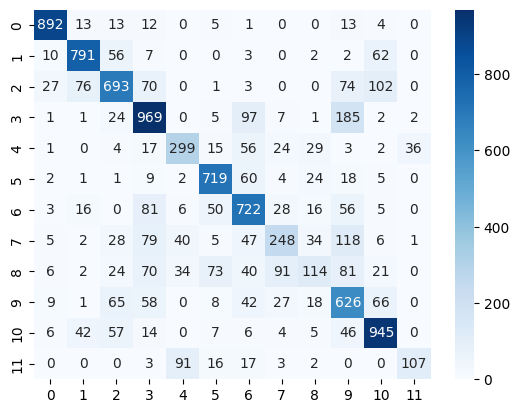

In [ ]:
print(classification_report(y_pred, small_y_test, digits=3))
plot_confusion_matrix(small_y_test, y_pred)

In [ ]:
name = 'SVM_partial'
pickle.dump(svm_clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
arr = y_train
print(set(list(arr)))
print(len(list(arr)))

arr = y_test
print(set(list(arr)))
print(len(list(arr)))

# Neural Network

In [ ]:

# NEURAL NETWORK (FULL DATA)

from keras import models, layers
from keras.layers import Input, Dense, Softmax, Dropout
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

batch_size= 64
epochs = 15
num_classes = 12
num_features = 52

model = models.Sequential()
model.add(Dense(512, activation='relu', input_dim=num_features))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Dropout(0.2))
model.add(Softmax())

model.compile(optimizer=SGD(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               27136     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 12)                6156      
                                                                 
 dropout_1 (Dropout)         (None, 12)                0         
                                                                 
 softmax (Softmax)           (None, 12)                0         
                                                                 
Total params: 33,292
Trainable params: 33,292
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
%%time
from keras.utils import to_categorical
from collections import defaultdict
# print(x_train.shape, y_train.shape)
# print(y_train)


d = defaultdict(int)
counter = 0
temp = []
for x in y_train:
  if x not in d:
    d[x] = counter
    counter += 1
  temp += [d[x]]

y_train = pd.Series(temp)
y_train_one_hot = to_categorical(temp, num_classes=12)
# print(y_train_one_hot.shape, type(y_train_one_hot))
# x_train = x_train.to_numpy()
# print(x_train.shape, type(x_train))

# print(x_train.shape, y_train)
# x_train = x_train[:, 1:]
# print(x_train)
model.fit(x_train, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

(1651441, 52) 0          0
1          1
2          2
3          3
4          4
          ..
1651436    3
1651437    7
1651438    9
1651439    6
1651440    6
Length: 1651441, dtype: int64
Epoch 1/15
20643/20643 [==============================] - 77s 4ms/step - loss: 1.2062 - accuracy: 0.6281 - val_loss: 0.6502 - val_accuracy: 0.8522
Epoch 2/15
20643/20643 [==============================] - 78s 4ms/step - loss: 0.8027 - accuracy: 0.7357 - val_loss: 0.4575 - val_accuracy: 0.8886
Epoch 3/15
20643/20643 [==============================] - 79s 4ms/step - loss: 0.6929 - accuracy: 0.7619 - val_loss: 0.3697 - val_accuracy: 0.9071
Epoch 4/15
20643/20643 [==============================] - 64s 3ms/step - loss: 0.6331 - accuracy: 0.7764 - val_loss: 0.3178 - val_accuracy: 0.9184
Epoch 5/15
20643/20643 [==============================] - 75s 4ms/step - loss: 0.5947 - accuracy: 0.7854 - val_loss: 0.2826 - val_accuracy: 0.9256
Epoch 6/15
20643/20643 [==============================] - 83s 4ms/step - loss:

In [ ]:
%%time 
y_pred = model.predict(x_test).argmax(axis=-1).tolist()
d_rev = {d[x]:x for x in d}
for i in range(len(y_pred)):
  y_pred[i] = d_rev[y_pred[i]]

9108/9108 [==============================] - 14s 2ms/step
CPU times: user 18 s, sys: 1.18 s, total: 19.1 s
Wall time: 17.8 s


              precision    recall  f1-score   support

           1    0.98898   0.99449   0.99173     28877
           2    0.96669   0.98310   0.97482     27510
           3    0.96456   0.93599   0.95006     29168
           4    0.97207   0.95489   0.96340     36709
           5    0.97060   0.98532   0.97791     14443
           6    0.97685   0.98932   0.98305     24439
           7    0.97727   0.95578   0.96640     28696
          12    0.86139   0.88337   0.87224     17088
          13    0.83965   0.90483   0.87102     14584
          16    0.94463   0.93265   0.93860     26650
          17    0.97274   0.96432   0.96851     35928
          24    0.97515   0.98392   0.97952      7339

    accuracy                        0.95723    291431
   macro avg    0.95088   0.95566   0.95311    291431
weighted avg    0.95786   0.95723   0.95741    291431



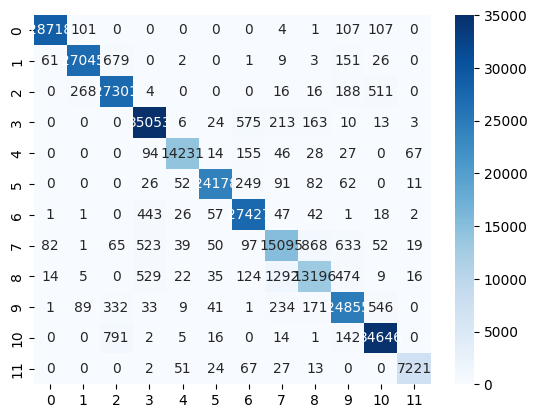

In [ ]:
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.save('neural_network_full')
!zip -r ./neural_network_full.zip ./neural_network_full

  adding: neural_network_full/ (stored 0%)
  adding: neural_network_full/assets/ (stored 0%)
  adding: neural_network_full/saved_model.pb (deflated 88%)
  adding: neural_network_full/variables/ (stored 0%)
  adding: neural_network_full/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: neural_network_full/variables/variables.index (deflated 51%)
  adding: neural_network_full/keras_metadata.pb (deflated 86%)
  adding: neural_network_full/fingerprint.pb (stored 0%)


In [ ]:

# NEURAL NETWORK (Partial Data)

from keras import models, layers
from keras.layers import Input, Dense, Softmax, Dropout
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy

batch_size= 64
epochs = 15
num_classes = 12
num_features = 18

model = models.Sequential()
model.add(Dense(512, activation='relu', input_dim=num_features))
model.add(Dropout(0.2))
model.add(Dense(num_classes))
model.add(Dropout(0.2))
model.add(Softmax())

model.compile(optimizer=SGD(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               9728      
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                6156      
                                                                 
 dropout_3 (Dropout)         (None, 12)                0         
                                                                 
 softmax_1 (Softmax)         (None, 12)                0         
                                                                 
Total params: 15,884
Trainable params: 15,884
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x_train_handIMU, y_train_one_hot, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Epoch 1/15
20643/20643 [==============================] - 72s 3ms/step - loss: 1.5635 - accuracy: 0.5194 - val_loss: 1.1080 - val_accuracy: 0.7055
Epoch 2/15
20643/20643 [==============================] - 70s 3ms/step - loss: 1.2049 - accuracy: 0.6110 - val_loss: 0.9075 - val_accuracy: 0.7480
Epoch 3/15
20643/20643 [==============================] - 77s 4ms/step - loss: 1.0930 - accuracy: 0.6415 - val_loss: 0.8059 - val_accuracy: 0.7711
Epoch 4/15
20643/20643 [==============================] - 67s 3ms/step - loss: 1.0298 - accuracy: 0.6590 - val_loss: 0.7420 - val_accuracy: 0.7873
Epoch 5/15
20643/20643 [==============================] - 60s 3ms/step - loss: 0.9847 - accuracy: 0.6720 - val_loss: 0.6958 - val_accuracy: 0.7997
Epoch 6/15
20643/20643 [==============================] - 62s 3ms/step - loss: 0.9503 - accuracy: 0.6816 - val_loss: 0.6604 - val_accuracy: 0.8105
Epoch 7/15
20643/20643 [==============================] - 62s 3ms/step - loss: 0.9248 - accuracy: 0.6889 - val_loss: 0

In [ ]:
%%time 
y_pred = model.predict(x_test_handIMU).argmax(axis=-1).tolist()
d_rev = {d[x]:x for x in d}
print(d)
print(d_rev)
for i in range(len(y_pred)):
  y_pred[i] = d_rev[y_pred[i]]


9108/9108 [==============================] - 14s 1ms/step
defaultdict(<class 'int'>, {6: 0, 13: 1, 1: 2, 4: 3, 5: 4, 17: 5, 3: 6, 2: 7, 7: 8, 16: 9, 24: 10, 12: 11})
{0: 6, 1: 13, 2: 1, 3: 4, 4: 5, 5: 17, 6: 3, 7: 2, 8: 7, 9: 16, 10: 24, 11: 12}
CPU times: user 19.5 s, sys: 1.22 s, total: 20.7 s
Wall time: 20.6 s


              precision    recall  f1-score   support

           1    0.94156   0.97271   0.95688     28108
           2    0.93370   0.92941   0.93155     28106
           3    0.84942   0.81440   0.83154     29521
           4    0.90691   0.82573   0.86442     39605
           5    0.86325   0.92172   0.89153     13732
           6    0.93972   0.90379   0.92140     25735
           7    0.91053   0.86853   0.88904     29422
          12    0.61088   0.69658   0.65092     15368
          13    0.43433   0.72073   0.54203      9471
          16    0.77052   0.72286   0.74593     28047
          17    0.93161   0.88440   0.90739     37518
          24    0.83052   0.90468   0.86601      6798

    accuracy                        0.85377    291431
   macro avg    0.82691   0.84713   0.83322    291431
weighted avg    0.86552   0.85377   0.85771    291431



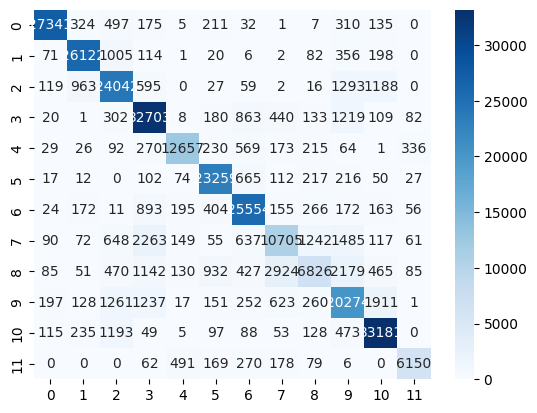

In [ ]:
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
model.save('neural_network_partial')
!zip -r ./neural_network_partial.zip ./neural_network_partial

  adding: neural_network_partial/ (stored 0%)
  adding: neural_network_partial/assets/ (stored 0%)
  adding: neural_network_partial/saved_model.pb (deflated 88%)
  adding: neural_network_partial/variables/ (stored 0%)
  adding: neural_network_partial/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: neural_network_partial/variables/variables.index (deflated 51%)
  adding: neural_network_partial/keras_metadata.pb (deflated 86%)
  adding: neural_network_partial/fingerprint.pb (stored 0%)


# Ordinary Decision Tree

In [ ]:
%%time

# ORDINARY DECISION TREE (Full Data)

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 15, random_state = 0, min_samples_split=10)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

CPU times: user 4min 38s, sys: 24.2 ms, total: 4min 38s
Wall time: 4min 49s


              precision    recall  f1-score   support

           1    0.99838   0.99983   0.99910     28996
           2    0.99267   0.99957   0.99611     27784
           3    0.99064   0.97847   0.98452     28656
           4    0.99526   0.96320   0.97897     37260
           5    0.98834   0.98659   0.98746     14688
           6    0.98788   0.99613   0.99199     24546
           7    0.98671   0.99383   0.99026     27864
          12    0.94225   0.97027   0.95605     17018
          13    0.94515   0.96643   0.95567     15370
          16    0.97568   0.98075   0.97820     26176
          17    0.98838   0.98619   0.98728     35696
          24    0.98987   0.99363   0.99175      7377

    accuracy                        0.98444    291431
   macro avg    0.98177   0.98457   0.98311    291431
weighted avg    0.98460   0.98444   0.98446    291431



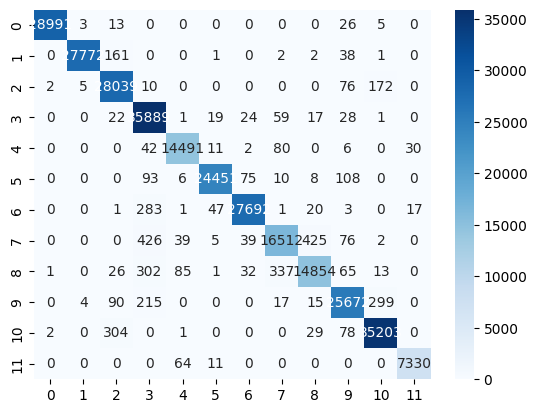

In [ ]:
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'decision_tree_full'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time

# ORDINARY DECISION TREE (Partial Data)

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(max_depth = 15, random_state = 0, min_samples_split=10)
clf.fit(x_train_handIMU, y_train)
y_pred = clf.predict(x_test_handIMU)

CPU times: user 1min 45s, sys: 82.6 ms, total: 1min 45s
Wall time: 1min 51s


              precision    recall  f1-score   support

           1    0.99149   0.99420   0.99284     28959
           2    0.97802   0.98541   0.98170     27767
           3    0.97983   0.95776   0.96867     28956
           4    0.98131   0.97622   0.97876     36248
           5    0.98847   0.98922   0.98884     14651
           6    0.97612   0.98681   0.98144     24483
           7    0.98927   0.98566   0.98746     28168
          12    0.94722   0.94189   0.94455     17623
          13    0.93694   0.97491   0.95555     15104
          16    0.96762   0.95693   0.96224     26606
          17    0.98144   0.98249   0.98197     35579
          24    0.97947   0.99533   0.98734      7287

    accuracy                        0.97684    291431
   macro avg    0.97477   0.97724   0.97595    291431
weighted avg    0.97691   0.97684   0.97684    291431



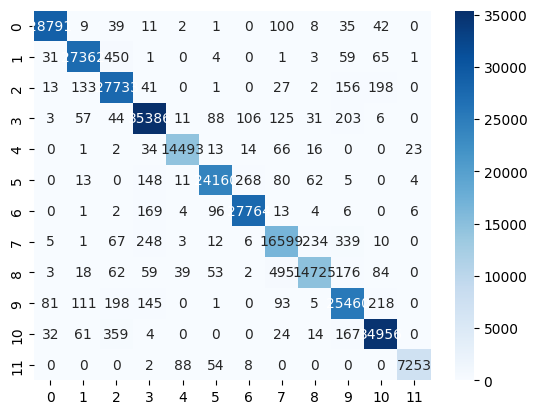

In [ ]:
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'decision_tree_partial'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Random Forest

In [8]:
%%time

# RANDOM FOREST (Full features)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0, verbose=2)
clf.fit(x_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.3s remaining:    0.0s


building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 31.1min finished


RandomForestClassifier(max_depth=3, n_estimators=300, random_state=0, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.0s finished
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 

              precision    recall  f1-score   support

           1    0.92665   1.00000   0.96193     26908
           2    0.94342   0.84183   0.88974     31353
           3    0.72923   0.78286   0.75509     26365
           4    0.93120   0.38339   0.54316     87584
           5    0.00934   0.60352   0.01840       227
           6    0.91701   0.67631   0.77848     33560
           7    0.31580   0.49578   0.38583     17877
          12    0.00000   0.00000   0.00000         0
          13    0.00000   0.00000   0.00000         0
          16    0.54701   0.83890   0.66222     17157
          17    0.95311   0.67502   0.79032     50290
          24    0.01256   0.84545   0.02475       110

    accuracy                        0.64390    291431
   macro avg    0.52378   0.59526   0.48416    291431
weighted avg    0.85454   0.64390   0.70479    291431



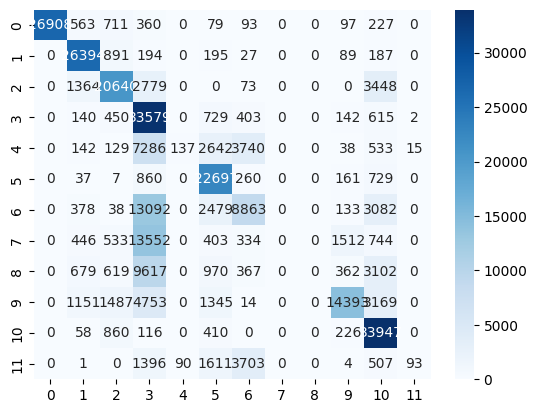

In [9]:
y_pred = clf.predict(x_test)
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [10]:
name = 'random_forest_full'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time

# RANDOM FOREST (Partial features)

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, max_depth=3, random_state=0, verbose=2)
clf.fit(x_train_handIMU, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 300


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


building tree 2 of 300
building tree 3 of 300
building tree 4 of 300
building tree 5 of 300
building tree 6 of 300
building tree 7 of 300
building tree 8 of 300
building tree 9 of 300
building tree 10 of 300
building tree 11 of 300
building tree 12 of 300
building tree 13 of 300
building tree 14 of 300
building tree 15 of 300
building tree 16 of 300
building tree 17 of 300
building tree 18 of 300
building tree 19 of 300
building tree 20 of 300
building tree 21 of 300
building tree 22 of 300
building tree 23 of 300
building tree 24 of 300
building tree 25 of 300
building tree 26 of 300
building tree 27 of 300
building tree 28 of 300
building tree 29 of 300
building tree 30 of 300
building tree 31 of 300
building tree 32 of 300
building tree 33 of 300
building tree 34 of 300
building tree 35 of 300
building tree 36 of 300
building tree 37 of 300
building tree 38 of 300
building tree 39 of 300
building tree 40 of 300
building tree 41 of 300
building tree 42 of 300
building tree 43 of 300


[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed: 18.4min finished


RandomForestClassifier(max_depth=3, n_estimators=300, random_state=0, verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   10.1s finished
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 

              precision    recall  f1-score   support

           1    0.91181   0.81280   0.85946     32575
           2    0.77328   0.89790   0.83094     24094
           3    0.61034   0.65181   0.63039     26503
           4    0.89029   0.35109   0.50358     91442
           5    0.29273   0.81411   0.43062      5272
           6    0.78930   0.59925   0.68127     32601
           7    0.59576   0.53466   0.56356     31272
          12    0.00000   0.00000   0.00000         0
          13    0.00000   0.00000   0.00000         0
          16    0.13971   0.63875   0.22927      5755
          17    0.85403   0.72567   0.78464     41917
          24    0.00000   0.00000   0.00000         0

    accuracy                        0.59064    291431
   macro avg    0.48810   0.50217   0.45948    291431
weighted avg    0.78381   0.59064   0.64196    291431



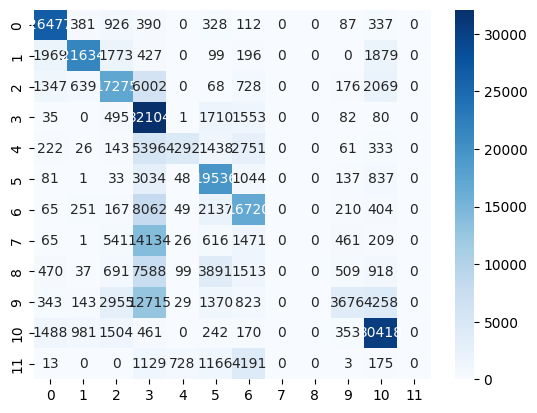

In [ ]:
y_pred = clf.predict(x_test_handIMU)
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'random_forest_partial'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Boosted Decision Trees

In [ ]:
%%time
# BOOSTED DECISION TREE (Full Data)

# AdaBoostClassifier uses SAMME algorithm which is not decision tree.
from sklearn.ensemble import HistGradientBoostingClassifier
clf = HistGradientBoostingClassifier(learning_rate=0.05, max_depth=3, random_state=0, verbose=2, max_iter=600)
clf.fit(x_train, y_train)

Binning 0.618 GB of training data: 8.871 s
Binning 0.069 GB of validation data: 1.993 s
Fitting gradient boosted rounds:
[1/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 2.11493, val loss: 2.11584, in 4.092s
[2/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.92110, val loss: 1.92208, in 3.152s
[3/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.77132, val loss: 1.77262, in 3.164s
[4/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.64364, val loss: 1.64530, in 5.926s
[5/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.53609, val loss: 1.53796, in 3.268s
[6/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.43853, val loss: 1.44046, in 3.521s
[7/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.35300, val loss: 1.35521, in 9.633s
[8/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.27741, val loss: 1.27972, in 3.591s
[9/600] 12 trees, 96 leaves (8 on avg),

HistGradientBoostingClassifier(learning_rate=0.05, max_depth=3, max_iter=600,
                               random_state=0, verbose=2)

              precision    recall  f1-score   support

           1    1.00000   1.00000   1.00000     29038
           2    0.99993   0.99993   0.99993     27977
           3    0.99961   0.99982   0.99972     28298
           4    1.00000   1.00000   1.00000     36060
           5    1.00000   1.00000   1.00000     14662
           6    1.00000   1.00000   1.00000     24751
           7    1.00000   1.00000   1.00000     28065
          12    0.99920   0.99943   0.99932     17520
          13    0.99936   0.99911   0.99924     15720
          16    1.00000   1.00000   1.00000     26312
          17    0.99992   0.99975   0.99983     35623
          24    1.00000   1.00000   1.00000      7405

    accuracy                        0.99986    291431
   macro avg    0.99984   0.99984   0.99984    291431
weighted avg    0.99986   0.99986   0.99986    291431



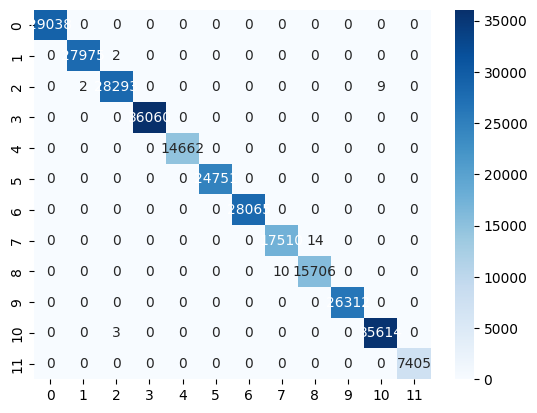

In [ ]:
y_pred = clf.predict(x_test)
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'boosted_tree_full'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
%%time
# BOOSTED DECISION TREE (Partial Data)

# AdaBoostClassifier uses SAMME algorithm which is not decision tree.
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
# clf = AdaBoostClassifier(n_estimators=100, random_state=0)
# clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=2, random_state=0, verbose=2)
clf = HistGradientBoostingClassifier(learning_rate=0.05, max_depth=3, random_state=0, verbose=2, max_iter=600)
clf.fit(x_train_handIMU, y_train)


Binning 0.214 GB of training data: 2.303 s
Binning 0.024 GB of validation data: 0.173 s
Fitting gradient boosted rounds:
[1/600] 12 trees, 95 leaves (7 on avg), max depth = 3, train loss: 2.17087, val loss: 2.17117, in 4.847s
[2/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 2.00149, val loss: 2.00199, in 1.982s
[3/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.86857, val loss: 1.86913, in 1.949s
[4/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.75932, val loss: 1.75999, in 1.963s
[5/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.66686, val loss: 1.66762, in 1.988s
[6/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.58632, val loss: 1.58714, in 4.985s
[7/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.51279, val loss: 1.51374, in 2.032s
[8/600] 12 trees, 96 leaves (8 on avg), max depth = 3, train loss: 1.44849, val loss: 1.44944, in 2.064s
[9/600] 12 trees, 96 leaves (8 on avg),

              precision    recall  f1-score   support

           1    0.99869   0.99952   0.99910     29014
           2    0.99725   0.99857   0.99791     27940
           3    0.98972   0.98968   0.98970     28305
           4    0.99509   0.99097   0.99303     36210
           5    0.99775   0.99795   0.99785     14659
           6    0.99721   0.99709   0.99715     24754
           7    0.99786   0.99676   0.99731     28096
          12    0.94716   0.97246   0.95964     17068
          13    0.95737   0.96815   0.96273     15541
          16    0.97758   0.96525   0.97137     26648
          17    0.99107   0.98620   0.98863     35793
          24    0.99932   0.99959   0.99946      7403

    accuracy                        0.98883    291431
   macro avg    0.98717   0.98852   0.98782    291431
weighted avg    0.98891   0.98883   0.98886    291431



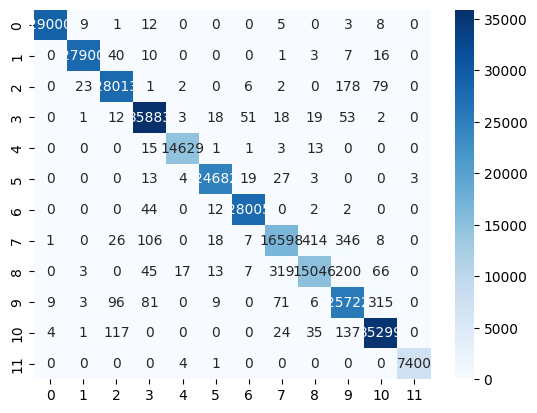

In [ ]:
y_pred = clf.predict(x_test_handIMU)
print(classification_report(y_pred, y_test, digits=5))
plot_confusion_matrix(y_test, y_pred)

In [ ]:
name = 'boosted_tree_partial'
pickle.dump(clf, open(name, 'wb'))
files.download(name) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>